# Test Run 5: Loose Candidates and Crowd Labeling Function

### Part I: Load loose candidates (prerequisite load documents from Test Run 1)

In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
debug_mode=1 # if not, debug_mode=0

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

from snorkel import SnorkelSession
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser
from snorkel.models import Document, Sentence

session = SnorkelSession()
print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

sents = session.query(Sentence).all()
n_max_corpus=0
for sent in sents:
    n_max_corpus=max(n_max_corpus,len(sent.words))

print("The longest sentence has "+str(n_max_corpus)+" tokens.")

from snorkel.models import Document
# from util import number_of_people

docs = session.query(Document).all()

train_sents = set()
dev_sents   = set()
test_sents  = set()

for i, doc in enumerate(docs):
    for s in doc.sentences:
        if i % 10 == 8 and "cscw18"!=doc.name[:6]:
#             dev_sents.add(s)
            continue
#         elif i % 10 == 9:
        elif "cscw18"==doc.name[:6]:  # replace the earlier 10% test documents as cscw'18 annotation guideline 10 examples
            test_sents.add(s)
        elif "cscw18"!=doc.name[:6]:
            train_sents.add(s)
            
print(len(test_sents))

Documents: 5560
Sentences: 18880
The longest sentence has 157 tokens.
66


In [2]:
from snorkel.models import candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import *

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    

def extract_and_display(matcher,candidate_class,candidate_class_name,document_breakdown_map=None,test_doc_breakdown_map=None,selected_split=0,is_print=True):  # split over train/dev/test but returns only train set
#     input(candidate_class)
    for (i, sents) in ([(0,train_sents), (1,dev_sents), (2,test_sents)] if selected_split==0 else ([(2,test_sents)] if selected_split==2 else [(1,dev_sents)])):
        %time matcher.apply(sents, split=i)
        printmd("**Split "+str(i)+" - number of candidates extracted: "+str(session.query(candidate_class).filter(candidate_class.split == i).count())+"**\n\n")
    cands = session.query(candidate_class).filter(candidate_class.split == selected_split).all()
    if is_print:
        for i in range(min(4,len(cands))): # to print at most 4 cands 
            printmd("**"+str(i)+"/"+str(len(cands))+" Candidate/Span:**\t`"+str(cands[i])+"`")
            printmd("**Its parent Sentence's text:**\t"+str(cands[i].get_parent().text))
            printmd("**Its parent Document's text:**\t"+str(cands[i].get_parent().get_parent().__dict__))
            print() 
        
    for cand in cands:
#         print(cand.__dict__)
        doc_name=cand.get_parent().get_parent().name
        if doc_name not in document_breakdown_map:
            document_breakdown_map[doc_name]=dict()
        if candidate_class_name not in document_breakdown_map[doc_name]:
            document_breakdown_map[doc_name][candidate_class_name]=[]
        document_breakdown_map[doc_name][candidate_class_name]+=[cand]
        
    cands = session.query(candidate_class).filter(candidate_class.split == 2).all()
    for cand in cands:
#         print(cand.__dict__)
        doc_name=cand.get_parent().get_parent().name
        if doc_name not in test_doc_breakdown_map:
            test_doc_breakdown_map[doc_name]=dict()
        if candidate_class_name not in test_doc_breakdown_map[doc_name]:
            test_doc_breakdown_map[doc_name][candidate_class_name]=[]
        test_doc_breakdown_map[doc_name][candidate_class_name]+=[cand]
    
    return cands


# In this section, we want to split sentences into comma-separated candidates (named as segments)
# In train split, we have number of candidates extracted: 31595, corresponding to 5560 * 0.9 = 5004 Documents
Segment = candidate_subclass('Segment', ['segment_cue'])
ngrams = Ngrams(n_max=n_max_corpus) # we define the maximum n value as n_max_corpus
non_comma_matcher=DictionaryMatch(d=[','],longest_match_only=True,reverse=True)  
non_comma_segment_extractor=CandidateExtractor(Segment, [ngrams], [non_comma_matcher])
train_doc_breakdown_map=dict() # maps doc_id into a dict of ["Background", "Purpose", "Mechanism", "Method", "Finding"]
test_doc_breakdown_map=dict()
segments=extract_and_display(non_comma_segment_extractor,Segment,"Segment",train_doc_breakdown_map,test_doc_breakdown_map)    

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 8s, sys: 730 ms, total: 1min 9s
Wall time: 1min 10s


**Split 0 - number of candidates extracted: 31595**



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 11.9 ms, sys: 1.88 ms, total: 13.7 ms
Wall time: 14.2 ms


**Split 1 - number of candidates extracted: 0**



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 617 ms, sys: 50.7 ms, total: 668 ms
Wall time: 660 ms


**Split 2 - number of candidates extracted: 138**



**0/31595 Candidate/Span:**	`Segment(Span("b'. .'", sentence=8382, chars=[0,2], words=[0,1]))`

**Its parent Sentence's text:**	. .

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x115af4cc0>, 'name': '5834868425ff05a97b00e493', 'stable_id': '5834868425ff05a97b00e493::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 796, 'type': 'document', 'sentences': [Sentence(Document 5834868425ff05a97b00e493,0,b'SPECIAL ISSUE PAPERS Enabling Multimodal Human\xe2\x80\x93'), Sentence(Document 5834868425ff05a97b00e493,1,b'Robot Interaction for the Karlsruhe Humanoid \\nRobot . .'), Sentence(Document 5834868425ff05a97b00e493,2,b'. .'), Sentence(Document 5834868425ff05a97b00e493,3,b'. .'), Sentence(Document 5834868425ff05a97b00e493,4,b'. .'), Sentence(Document 5834868425ff05a97b00e493,5,b'. .'), Sentence(Document 5834868425ff05a97b00e493,6,b'. .'), Sentence(Document 5834868425ff05a97b00e493,7,b'. .'), Sentence(Document 5834868425ff05a97b00e493,8,b'. .'), Sentence(Document 5834868425ff05a97b00e493,9,b'. .'), Sentence(Document 5834868425ff05a97b00e493,10,b'. .'), Sentence(Document 5834868425ff05a97b00e493,11,b'. .'), Sentence(Document 5834868425ff05a97b00e493,12,b'. .'), Sentence(Document 5834868425ff05a97b00e493,13,b'. .'), Sentence(Document 5834868425ff05a97b00e493,14,b'. .'), Sentence(Document 5834868425ff05a97b00e493,15,b'. .'), Sentence(Document 5834868425ff05a97b00e493,16,b'. .'), Sentence(Document 5834868425ff05a97b00e493,17,b'. .'), Sentence(Document 5834868425ff05a97b00e493,18,b'. .'), Sentence(Document 5834868425ff05a97b00e493,19,b'. .'), Sentence(Document 5834868425ff05a97b00e493,20,b'. .'), Sentence(Document 5834868425ff05a97b00e493,21,b'. .'), Sentence(Document 5834868425ff05a97b00e493,22,b'. .'), Sentence(Document 5834868425ff05a97b00e493,23,b'. .'), Sentence(Document 5834868425ff05a97b00e493,24,b'. .'), Sentence(Document 5834868425ff05a97b00e493,25,b'.'), Sentence(Document 5834868425ff05a97b00e493,26,b'.'), Sentence(Document 5834868425ff05a97b00e493,27,b'R. Stiefelhagen, HK Ekenel, \\nC. F\xc3\xbcgen, P. Gieselmann, H. Holzapfel, F. Kraft, K. Nickel, M. Voit, and A. Waibel   Human-Oriented \\nInteraction With an Anthropomorphic Robot . . . . . . . . . . . . . . . . . .'), Sentence(Document 5834868425ff05a97b00e493,28,b'.'), Sentence(Document 5834868425ff05a97b00e493,29,b'TP Spexard, M. Hanheide, and \\nG. Sagerer   A Linear Affect\xe2\x80\x93Expression Space Model and Control Points for Mascot-Type Facial \\nRobot . .'), Sentence(Document 5834868425ff05a97b00e493,30,b'. .'), Sentence(Document 5834868425ff05a97b00e493,31,b'. .'), Sentence(Document 5834868425ff05a97b00e493,32,b'. .'), Sentence(Document 5834868425ff05a97b00e493,33,b'. .'), Sentence(Document 5834868425ff05a97b00e493,34,b'. .'), Sentence(Document 5834868425ff05a97b00e493,35,b'. .'), Sentence(Document 5834868425ff05a97b00e493,36,b'. .'), Sentence(Document 5834868425ff05a97b00e493,37,b'. .'), Sentence(Document 5834868425ff05a97b00e493,38,b'. .'), Sentence(Document 5834868425ff05a97b00e493,39,b'. .'), Sentence(Document 5834868425ff05a97b00e493,40,b'. .'), Sentence(Document 5834868425ff05a97b00e493,41,b'. .'), Sentence(Document 5834868425ff05a97b00e493,42,b'. .'), Sentence(Document 5834868425ff05a97b00e493,43,b'. .'), Sentence(Document 5834868425ff05a97b00e493,44,b'. .'), Sentence(Document 5834868425ff05a97b00e493,45,b'. .'), Sentence(Document 5834868425ff05a97b00e493,46,b'. .'), Sentence(Document 5834868425ff05a97b00e493,47,b'. .'), Sentence(Document 5834868425ff05a97b00e493,48,b'. .'), Sentence(Document 5834868425ff05a97b00e493,49,b'. .'), Sentence(Document 5834868425ff05a97b00e493,50,b'. .'), Sentence(Document 5834868425ff05a97b00e493,51,b'. .'), Sentence(Document 5834868425ff05a97b00e493,52,b'. .'), Sentence(Document 5834868425ff05a97b00e493,53,b'. .'), Sentence(Document 5834868425ff05a97b00e493,54,b'. .'), Sentence(Document 5834868425ff05a97b00e493,55,b'. .'), Sentence(Document 5834868425ff05a97b00e493,56,b'. .'), Sentence(Document 5834868425ff05a97b00e493,57,b'. .'), Sentence(Document 5834868425ff05a97b00e493,58,b'. .'), Sentence(Document 5834868425ff05a97b00e493,59,b'. .'), Sentence(Document 5834868425ff05a97b00e493,60,b'. .'), Sentence(Document 5834868425ff05a97b00e493,61,b'. .'), Sentence(Document 5834868425ff05a97b00e493,62,b'. .'), Sentence(Document 5834868425ff05a97b00e493,63,b'. .'), Sentence(Document 5834868425ff05a97b00e493,64,b'. .'), Sentence(Document 5834868425ff05a97b00e493,65,b'. .'), Sentence(Document 5834868425ff05a97b00e493,66,b'.\n')]}

**1/31595 Candidate/Span:**	`Segment(Span("b'It is our great pleasure to warmly welcome you to the 2013 IEEE/WIC/ACM International Conference on Web Intelligence (WI 2013).'", sentence=17365, chars=[0,126], words=[0,26]))`

**Its parent Sentence's text:**	It is our great pleasure to warmly welcome you to the 2013 IEEE/WIC/ACM International Conference on Web Intelligence (WI 2013).

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1163f7a58>, 'name': '5834868825ff05a97b016e23', 'stable_id': '5834868825ff05a97b016e23::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 3451, 'type': 'document', 'sentences': [Sentence(Document 5834868825ff05a97b016e23,0,b'It is our great pleasure to warmly welcome you to the 2013 IEEE/WIC/ACM International Conference on Web Intelligence (WI 2013).'), Sentence(Document 5834868825ff05a97b016e23,1,b'WI 2013 is the 12th edition of its series.'), Sentence(Document 5834868825ff05a97b016e23,2,b'On behalf of the WI 2013 Conference Committees, we would like to thank you for your contributions and participation, and we do hope that you will enjoy the technical events and social programs, and will have wonderful time at Atlanta.\n')]}

**2/31595 Candidate/Span:**	`Segment(Span("b'and forty.'", sentence=23479, chars=[54,63], words=[10,12]))`

**Its parent Sentence's text:**	Fifty six million, six hundred eighty seven thousand, and forty.

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x121d05b00>, 'name': '5942b359c50f90cdd3b1f54d', 'stable_id': '5942b359c50f90cdd3b1f54d::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 5276, 'type': 'document', 'sentences': [Sentence(Document 5942b359c50f90cdd3b1f54d,0,b'Fifty six million, six hundred eighty seven thousand, and forty.'), Sentence(Document 5942b359c50f90cdd3b1f54d,1,b'A big number, to be sure.'), Sentence(Document 5942b359c50f90cdd3b1f54d,2,b'This is the number of possible semantic analyses for an average sized sentence in the Mikrokosmos Machine Translation project.'), Sentence(Document 5942b359c50f90cdd3b1f54d,3,b'Complex sentences have gone past the trillions.'), Sentence(Document 5942b359c50f90cdd3b1f54d,4,b'If every combination could be accurately judged in one thousandth of a second, it would still take almost a day to analyze the average sentence.'), Sentence(Document 5942b359c50f90cdd3b1f54d,5,b'And you can forget about the hard ones.'), Sentence(Document 5942b359c50f90cdd3b1f54d,6,b'And yet, understanding natural language sentences is intuitively not an exponential a air.\n')]}

**3/31595 Candidate/Span:**	`Segment(Span("b'six hundred eighty seven thousand'", sentence=23479, chars=[19,51], words=[4,8]))`

**Its parent Sentence's text:**	Fifty six million, six hundred eighty seven thousand, and forty.

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x121d05b00>, 'name': '5942b359c50f90cdd3b1f54d', 'stable_id': '5942b359c50f90cdd3b1f54d::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 5276, 'type': 'document', 'sentences': [Sentence(Document 5942b359c50f90cdd3b1f54d,0,b'Fifty six million, six hundred eighty seven thousand, and forty.'), Sentence(Document 5942b359c50f90cdd3b1f54d,1,b'A big number, to be sure.'), Sentence(Document 5942b359c50f90cdd3b1f54d,2,b'This is the number of possible semantic analyses for an average sized sentence in the Mikrokosmos Machine Translation project.'), Sentence(Document 5942b359c50f90cdd3b1f54d,3,b'Complex sentences have gone past the trillions.'), Sentence(Document 5942b359c50f90cdd3b1f54d,4,b'If every combination could be accurately judged in one thousandth of a second, it would still take almost a day to analyze the average sentence.'), Sentence(Document 5942b359c50f90cdd3b1f54d,5,b'And you can forget about the hard ones.'), Sentence(Document 5942b359c50f90cdd3b1f54d,6,b'And yet, understanding natural language sentences is intuitively not an exponential a air.\n')]}

In [10]:
segments=session.query(Segment).filter(Segment.split==0).all()
segments

SyntaxError: keyword can't be an expression (<ipython-input-10-3bd5f0d07104>, line 1)

### Part II: Loading Gold Labels (Encountered some issue and slightly deprecated)

In [4]:
from util import load_external_labels
from snorkel.annotations import load_gold_labels
# if load the 1st time
# purposes = load_external_labels(session, Segment, annotator_name='background')

# else:
gold_dev_purposes_mixed_w_backgrounds=load_gold_labels(session, annotator_name='background', split=1)
print(type(gold_dev_purposes_mixed_w_backgrounds))

<class 'snorkel.annotations.csr_LabelMatrix'>


### Part III: Defining Labeling Function (for Purpose and Mechanism) 

Recall a labeling function is just a Python function that accepts a Candidate (in our case, Segments), and returns 1 to mark the Candidate as true, -1 to mark the Candidate as false, and 0 to abstain from labeling the Candidate. Let's start by defining some Purpose labeling function. 

In [3]:
import re
from snorkel.lf_helpers import *

def LF_expressing_contrast(c):
    return 1 if rule_regex_search_candidate_text(c,"((^|\s)(however|nevertheless|despite|spite|yet).*$)|((^|\s)but(?!(also))*$)",1) else 0

def LF_excluded_pseudo_contrast(c):
    return -1 if rule_regex_search_candidate_text(c,"(^.*but sometimes.*$)|(^.*but also.*$)",1) else 0

def LF_comparative_degree(c):
    return 1 if rule_regex_search_candidate_text(c,"(.*more.*than.*$)|(.*er than.*$)",1) else 0

def LF_purpose_verb(c):
    return 1 if rule_regex_search_candidate_text(c,"(.*in order to.*$)|(.* implication.*$)|(.* to solve.*$)|(.* hypothesis.*$)|(.*to enable.*$)|(.*to aid.*$)|(.*to produce.*$)|(.*to investigat.*$)|(.* give.*$)|(.* that can .*$)|(.* examine.*$)|(.* extend.*$)|(.* offer.*$)",1) else 0

def LF_purpose_delimiter(c):
    return 1 if rule_regex_search_candidate_text(c,"(.*in this paper.*$)|(.*in the paper.*$)|(.*in this study.*$)",1) else 0

def LF_purpose_adj_problem(c):
    return 1 if rule_regex_search_candidate_text(c,"(.* challenging.*$)|(.* captivating.*$)|(.* engaging.*$)|(.* interesting.*$)",1) else 0

def LF_purpose_leading_question_word(c):
    return 1 if rule_regex_search_candidate_text(c,"(.*how to.*$)|(.*what .*$)|(.*why .*$)",1) else 0


def LF_mechanism_verb(c):
    return 1 if rule_regex_search_candidate_text(c,"((^|\s)(introduce|propose|develop|approach|applied|apply|using|present|contribute|build|built).*$)",1) else 0

# def LF_not_purpose_but_mechanism_verb(c):
#     return 0 if rule_regex_search_candidate_text(c,"((^|\s)(introduce|propose|develop|approach|applied|apply|using|present|contribute|build|built).*$)",1) else 1




def LF_mechanism_adv(c):
    return 1 if rule_regex_search_candidate_text(c,"((^|\s)(specifically|particularly|particular).*$)",1) else 0

def LF_mechanism_noun(c):
    return 1 if rule_regex_search_candidate_text(c,"((^|\s)(framework|algorithm|model|module|mechanism).*$)",1) else 0

def LF_mechanism_adj(c):
    return 1 if rule_regex_search_candidate_text(c,"((^|\s)(simple|general|effective|efficient).*$)",1) else 0

labeled = []
# negate=lambda x: -x

def negate(f):
    return lambda x: -f(x)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


##### First we examine the metrics for Purpose LFs

In [4]:
from snorkel.annotations import LabelAnnotator

purpose_LFs=[LF_expressing_contrast,LF_excluded_pseudo_contrast,LF_comparative_degree,LF_purpose_verb,LF_purpose_delimiter,LF_purpose_adj_problem,LF_purpose_leading_question_word,negate(LF_mechanism_verb),negate(LF_mechanism_adv),negate(LF_mechanism_noun),negate(LF_mechanism_adj)]

labeler = LabelAnnotator(lfs=purpose_LFs)

np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train


Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 2min 13s, sys: 819 ms, total: 2min 14s
Wall time: 2min 15s


<31595x8 sparse matrix of type '<class 'numpy.int64'>'
	with 6942 stored elements in Compressed Sparse Row format>

#### Take a peek at one of the labelled candidates and which LF does it come from 

In [8]:
print("A random candidate",L_train.get_candidate(session, 3))
print("Its LabelKey",L_train.get_key(session, 3))
# print("Annotations summary",L_train.stats())

A random candidate Segment(Span("b'Kinsey (1984) defined noncompliance with tax laws as the \xe2\x80\x9cfailure'", sentence=13067, chars=[0,64], words=[0,12]))
Its LabelKey LabelKey (LF_purpose_verb)


view statistics about the resulting label matrix.

* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a *conflicting* non-zero label for.

In [5]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_expressing_contrast,0,0.011173,0.000475,0.000317
LF_excluded_pseudo_contrast,1,0.001013,0.000158,0.000095
LF_comparative_degree,2,0.007501,0.001139,0.000855
LF_purpose_verb,3,0.034879,0.008134,0.006552
LF_purpose_delimiter,4,0.017060,0.003925,0.003482
LF_purpose_adj_problem,5,0.003482,0.000728,0.000506
LF_purpose_leading_question_word,6,0.008419,0.002595,0.001551
<lambda>,7,0.136192,0.012660,0.012597


##### Next we examine the metrics for Mechanism LFs

In [10]:
from snorkel.annotations import LabelAnnotator

mechanism_LFs=[LF_mechanism_verb, LF_mechanism_adv,LF_mechanism_noun, LF_mechanism_adj, negate(LF_expressing_contrast),negate(LF_excluded_pseudo_contrast),negate(LF_comparative_degree),negate(LF_purpose_verb),negate(LF_purpose_delimiter),negate(LF_purpose_adj_problem),negate(LF_purpose_leading_question_word)]
labeler = LabelAnnotator(lfs=mechanism_LFs)

np.random.seed(1702)
%time L_train_mechanism = labeler.apply(split=0)
L_train_mechanism



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 2min 46s, sys: 2.69 s, total: 2min 49s
Wall time: 2min 59s


<31595x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8523 stored elements in Compressed Sparse Row format>

In [11]:
L_train_mechanism.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_mechanism_verb,0,0.136192,0.031746,0.000317
LF_mechanism_adv,1,0.008831,0.001677,0.000032
LF_mechanism_noun,2,0.083209,0.030511,0.000285
LF_mechanism_adj,3,0.030353,0.011774,0.000095
<lambda>,4,0.011173,0.000696,0.000696


## 3. Fitting the Generative Model

The training step for 70K papers take approximately 10 mins. 

In [12]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()  # Inferred cardinality: 2 would be binary label (excluding the uncertain class)
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


Next we quantify a few characteristics, (1) LF accuracies; (2) the marginal probability distributions of each candidate being True

In [13]:
gen_model.weights.lf_accuracy

array([0.07856624, 0.07481565, 0.07709562, 0.08353626, 0.07912881,
       0.07455556, 0.07590932, 0.12232697])

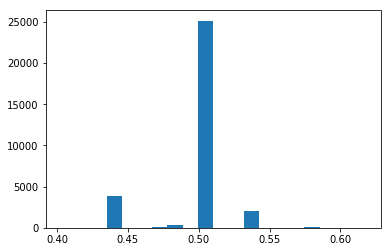

In [14]:
train_marginals = gen_model.marginals(L_train)
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [15]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.537883,0.6652,0.542201,0.362007
1,0.541904,0.6658,0.544689,0.360414
2,0.538233,0.6722,0.537371,0.362206
3,0.534887,0.6736,0.533137,0.360414
4,0.529306,0.6688,0.531137,0.349861
5,0.539391,0.6702,0.537954,0.357029
6,0.534796,0.6610,0.542962,0.354839
7,0.565314,0.6752,0.567007,0.386699


In [13]:
# Test one purpose LF over groundtruth ISSUE: gold_labels.tsv are context_stable_ids. How could we get that for our task 

from snorkel.lf_helpers import test_LF
tp, fp, tn, fn = test_LF(session, LF_expressing_contrast, split=1, annotator_name='background')


test_candidates # 0
Scores (Un-adjusted)
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



In [ ]:
cands=session.query(Segment).filter(Segment.split == 0).all()

for ind,c in enumerate(cands): # session.query(Segment).filter(Segment.split == 0).all():
    if ind%500==0:
        print("Processed ", ind, len(cands))
        
    for lf in LFS:
        if lf(c)!=0:
            labeled.append(c)
            continue
        
print("Number labeled:", len(labeled),len(cands))

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

from snorkel import SnorkelSession
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser
from snorkel.models import Document, Sentence


# Reference: 
# def load_external_labels(session, candidate_class, annotator_name='gold'):
#  session.add(StableLabel(
#                 context_stable_ids=context_stable_ids,
#                 annotator_name=annotator_name, e.g. "gold"
#                 value=row['label']))
            
            
GoldBackground = candidate_subclass('GoldBackground', ['goldbackground_cue'])

all_gold_background_extractor=CandidateExtractor(GoldBackground, [ngrams], None)


We want to differentiate ``Background`` with ``Purpose``. Recall our ``Background`` definition from Google Doc:

``Contains words that indicate prior work (e.g., “traditionally”, “researchers have…”), and then following sentence/span starts with some variant of “In this paper, we introduce…” (Exploring adjacency relationship through helper function in Snorkel)``


In [8]:
# remove if necessary 
# session.query(Background).all()
import snorkel.models.candidate as candidate

def del_defined_candidate_class(class_name):
    print("Existing", candidate.candidate_subclasses)
    del(candidate.candidate_subclasses[class_name])
    print("After deletion", candidate.candidate_subclasses)
    
## Usage:    
# del_defined_candidate_class('Purpose')

non_comma_matcher=DictionaryMatch(d=[','],longest_match_only=True,reverse=True)  

The next few cells describe our ``Span Matching`` phase: we respectively define the `Span` for the 5 segments are , and centrally stored in a document-id-indexed hashmap. This helps us to group the 5 segments back into documents.
3. Only those documents that have at least 3 segments are considered as valid

Following this ``Span Matching`` phase, we will be having an ``Document Aggregation`` phase, where adjacency relationship and (or) waterfall models are being emphasized through multiple criteria. For example, the following criteria prevents non-abstracts (e.g. proceeding cover letter, tutorial introduction, etc.) or less well-strctured abstracts from being included. 

1. Only those documents that have all 5 segments are considered as valid
2. Only those documents that have at least 4 segments are cosidered as valid

In [9]:
# Compound Matcher for Background: 
Background = candidate_subclass('Background', ['background_cue'])
transition_word=DictionaryMatch(d=['while','unlike','despite'],longest_match_only=True) 
transition_prev_work=DictionaryMatch(d=['previous','earlier','past'],longest_match_only=True) 
dict_background_matcher=DictionaryMatch(d=['previous work','traditionally','researchers'],longest_match_only=True) 
excluded_dict_background_matcher=DictionaryMatch(d=['we','unlike','our'],longest_match_only=True,reverse=True) 
non_comma_dict_background_matcher=CandidateExtractor(Background, [ngrams], [Intersection(non_comma_matcher,Union(dict_background_matcher,Intersection(transition_word,transition_prev_work)),excluded_dict_background_matcher)])
background_cands=extract_and_display(non_comma_dict_background_matcher,Background,"Background",document_breakdown_map)
# print(document_breakdown_map)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 28s, sys: 472 ms, total: 1min 29s
Wall time: 1min 29s


**Split 0 - number of candidates extracted: 148**



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 9.88 s, sys: 220 ms, total: 10.1 s
Wall time: 10.1 s


**Split 1 - number of candidates extracted: 15**



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 460 ms, sys: 22.7 ms, total: 483 ms
Wall time: 474 ms


**Split 2 - number of candidates extracted: 0**



**0/148 Candidate/Span:**	`Background(Span("b'The intersection of these domains should enable researchers to foster an improved understanding of student learning'", sentence=12057, chars=[0,114], words=[0,15]))`

**Its parent Sentence's text:**	The intersection of these domains should enable researchers to foster an improved understanding of student learning, lead to the creation of more natural and enriching learning interfaces, and motivate the development of novel techniques for tackling challenges that are specific of education.


**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x127d5e8d0>, 'name': '5834868625ff05a97b01354e', 'stable_id': '5834868625ff05a97b01354e::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 1886, 'type': 'document', 'sentences': [Sentence(Document 5834868625ff05a97b01354e,0,b'This summary describes the 1st International Workshop on Multimodal Learning Analytics.'), Sentence(Document 5834868625ff05a97b01354e,1,b'This area of study brings together the technologies of multimodal analysis with the learning sciences.'), Sentence(Document 5834868625ff05a97b01354e,2,b'The intersection of these domains should enable researchers to foster an improved understanding of student learning, lead to the creation of more natural and enriching learning interfaces, and motivate the development of novel techniques for tackling challenges that are specific of education.\n')]}

**1/148 Candidate/Span:**	`Background(Span("b'researchers appear to be intrigued with the question; Given a set of points'", sentence=5803, chars=[9,83], words=[3,16]))`

**Its parent Sentence's text:**	Of late, researchers appear to be intrigued with the question; Given a set of points, what is the region occupied by them?

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1113a94e0>, 'name': '5834868425ff05a97b00c32e', 'stable_id': '5834868425ff05a97b00c32e::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 72, 'type': 'document', 'sentences': [Sentence(Document 5834868425ff05a97b00c32e,0,b'Of late, researchers appear to be intrigued with the question; Given a set of points, what is the region occupied by them?'), Sentence(Document 5834868425ff05a97b00c32e,1,b'The answer appears to be neither straight forward nor unique.'), Sentence(Document 5834868425ff05a97b00c32e,2,b'Convex hull, which gives a convex enclosure of the given set, concave hull, which generates non-convex polygons and other variants such as \xce\xb1-hull, poly hull, r-shape and s-shape etc. have been proposed.'), Sentence(Document 5834868425ff05a97b00c32e,3,b'In this paper, we extend the question of finding a minimum area enclosure (MAE) to a set of closed planar freeform curves, not resorting to sampling them.\n')]}

**2/148 Candidate/Span:**	`Background(Span("b'The feature-interaction problem has been keeping researchers and practitioners in suspense for years.'", sentence=13452, chars=[0,100], words=[0,15]))`

**Its parent Sentence's text:**	The feature-interaction problem has been keeping researchers and practitioners in suspense for years.

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x127d8dba8>, 'name': '5834868625ff05a97b012212', 'stable_id': '5834868625ff05a97b012212::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 2305, 'type': 'document', 'sentences': [Sentence(Document 5834868625ff05a97b012212,0,b'The feature-interaction problem has been keeping researchers and practitioners in suspense for years.'), Sentence(Document 5834868625ff05a97b012212,1,b'Although there has been substantial progress in developing approaches for modeling, detecting, managing, and resolving feature interactions, we lack sufficient knowledge on the kind of feature interactions that occur in real-world systems.'), Sentence(Document 5834868625ff05a97b012212,2,b'In this position paper, we set out the goal to explore the nature of feature interactions systematically and comprehensively, classified in terms of order and visibility.\n')]}

**3/148 Candidate/Span:**	`Background(Span("b'previous work in this domain'", sentence=13892, chars=[7,34], words=[1,5]))`

**Its parent Sentence's text:**	Unlike previous work in this domain, which focused on taking one reference sample and doing user authentication based on the reference sample only, we continuously sample user input and use the data for identi cation and further learning and re nement of the user model.


**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x127d9b550>, 'name': '5834868725ff05a97b0141e7', 'stable_id': '5834868725ff05a97b0141e7::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 2438, 'type': 'document', 'sentences': [Sentence(Document 5834868725ff05a97b0141e7,0,b'We analyze keystroke latency patterns to identify the person typing on the keyboard.'), Sentence(Document 5834868725ff05a97b0141e7,1,b'Unlike previous work in this domain, which focused on taking one reference sample and doing user authentication based on the reference sample only, we continuously sample user input and use the data for identi cation and further learning and re nement of the user model.\n')]}

In [46]:
# Compound Matcher for Purpose:
Purpose=candidate_subclass('Purpose',['purpose_cue'])

transition_regex_matcher=RegexMatchSpan(rgx="((^|\s)however.*$)|((^|\s)but(?!(also))*$)",longest_match_only=True)  # Correction: purpose 
excluded_dict_purpose_matcher=SentenceMatch(d=['but also','but without','but sometimes'],longest_match_only=True,reverse=True)  # the parent sentence shall not include "but also"
transition_matcher=Intersection(transition_regex_matcher,excluded_dict_purpose_matcher)

comparative_degree_matcher=Intersection(RegexMatchSpan(rgx="(.*more.*than.*$)|(.*er than.*$)",longest_match_only=True),transition_prev_work)  # Correction: purpose 
other_regex_matcher=RegexMatchSpan(rgx="(.*extend.*$)|(.*offer.*$)",longest_match_only=True)

dict_purpose_matcher=DictionaryMatch(d=['in this paper','in the paper',' that can ','in this study','to examine','we examine','to investigate','implications'],longest_match_only=True) 

# Unit test
# non_comma_dict_purpose_matcher=CandidateExtractor(Purpose, [ngrams], [Intersection(non_comma_matcher,other_regex_matcher)])

non_comma_dict_purpose_matcher=CandidateExtractor(Purpose, [ngrams], [Intersection(non_comma_matcher,Union(comparative_degree_matcher,other_regex_matcher,dict_purpose_matcher,transition_matcher))]) #,intersection(excluded_dict_purpose_matcher,transition_regex_matcher)])
purpose_cands=extract_and_display(non_comma_dict_purpose_matcher,Purpose,"Purpose",document_breakdown_map)
# print(document_breakdown_map)

<class 'snorkel.models.candidate.Purpose'>
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 35s, sys: 1.38 s, total: 1min 37s
Wall time: 1min 38s


**Split 0 - number of candidates extracted: 1501**



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 11.8 s, sys: 468 ms, total: 12.3 s
Wall time: 12.2 s


**Split 1 - number of candidates extracted: 203**



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 761 ms, sys: 117 ms, total: 878 ms
Wall time: 878 ms


**Split 2 - number of candidates extracted: 10**



**0/1501 Candidate/Span:**	`Purpose(Span("b'In this paper'", sentence=21545, chars=[0,12], words=[0,2]))`

**Its parent Sentence's text:**	In this paper, we describe several experiments with image understanding algorithms that were developed to aid remote visual inspection, in enhancing and recognizing surface cracks and corrosion from the live imagery of an aircraft surface.


**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x11d85b278>, 'name': '58cb6b8ec50f90cdd3875b14', 'stable_id': '58cb6b8ec50f90cdd3875b14::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 4540, 'type': 'document', 'sentences': [Sentence(Document 58cb6b8ec50f90cdd3875b14,0,b'Visual inspection is, by far, the most widely used method in aircraft surface inspection.'), Sentence(Document 58cb6b8ec50f90cdd3875b14,1,b'We are currently developing a prototype remote visual inspection system, designed to facilitate testing the hypothesized feasibility and advantages of remote visual inspection of aircraft surfaces.'), Sentence(Document 58cb6b8ec50f90cdd3875b14,2,b'In this paper, we describe several experiments with image understanding algorithms that were developed to aid remote visual inspection, in enhancing and recognizing surface cracks and corrosion from the live imagery of an aircraft surface.\n')]}

**1/1501 Candidate/Span:**	`Purpose(Span("b'\xe2\x80\x94here we examine shrinkage toward diagonality.\n'", sentence=11574, chars=[0,46], words=[0,8]))`

**Its parent Sentence's text:**	—here we examine shrinkage toward diagonality.


**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1122c40f0>, 'name': '5834868625ff05a97b0122ab', 'stable_id': '5834868625ff05a97b0122ab::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 1681, 'type': 'document', 'sentences': [Sentence(Document 5834868625ff05a97b0122ab,0,b'The problem of estimating a covariance matrix in small samples has been considered by several authors following early work by Stein.'), Sentence(Document 5834868625ff05a97b0122ab,1,b'This problem can be especially important in hierarchical models where the standard errors of fixed and random effects depend on estimation of the covariance matrix of the distribution of the random effects.'), Sentence(Document 5834868625ff05a97b0122ab,2,b'We propose a set of hierarchical priors (HPs) for the covariance matrix that produce posterior shrinkage toward a specified structure'), Sentence(Document 5834868625ff05a97b0122ab,3,b'\xe2\x80\x94here we examine shrinkage toward diagonality.\n')]}

**2/1501 Candidate/Span:**	`Purpose(Span("b'which extend organisational boundaries.'", sentence=6712, chars=[119,157], words=[19,23]))`

**Its parent Sentence's text:**	The quest for scalability, reliability and cost reduction has led to the development of massively distributed systems, which extend organisational boundaries.

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x111488240>, 'name': '5834868425ff05a97b00e0fe', 'stable_id': '5834868425ff05a97b00e0fe::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 315, 'type': 'document', 'sentences': [Sentence(Document 5834868425ff05a97b00e0fe,0,b'Modern computing paradigms have frequently adopted concepts from distributed systems.'), Sentence(Document 5834868425ff05a97b00e0fe,1,b'The quest for scalability, reliability and cost reduction has led to the development of massively distributed systems, which extend organisational boundaries.'), Sentence(Document 5834868425ff05a97b00e0fe,2,b'Voluntary computing environments (such as BOINC), Grids (such as EGEE and Globus), and more recently Cloud Computing (both open source and commercial) have established themselves as a range of distributed systems.\n')]}

**3/1501 Candidate/Span:**	`Purpose(Span("b'however'", sentence=12099, chars=[5,11], words=[2,2]))`

**Its parent Sentence's text:**	Few, however, allow new interfaces to be created from scratch because they do not provide a means of demonstrating when a recorded macro should be invoked.

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1122fb828>, 'name': '5834868725ff05a97b013a8a', 'stable_id': '5834868725ff05a97b013a8a::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 1836, 'type': 'document', 'sentences': [Sentence(Document 5834868725ff05a97b013a8a,0,b'Many programming by demonstration (PBD) systems elaborate on the idea of macro recording, and they allow users to extend existing applications.'), Sentence(Document 5834868725ff05a97b013a8a,1,b'Few, however, allow new interfaces to be created from scratch because they do not provide a means of demonstrating when a recorded macro should be invoked.'), Sentence(Document 5834868725ff05a97b013a8a,2,b'This paper discusses stimulus-response systems that allow both the when (stimulus/event) and the what (response macro) to be demonstrated.\n')]}


10
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a21999fd0>, 'type': 'purpose', 'purpose_cue_cid': None, 'purpose_cue_id': 26962, 'split': 2, 'id': 1705}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a21990080>, 'type': 'purpose', 'purpose_cue_cid': None, 'purpose_cue_id': 26963, 'split': 2, 'id': 1706}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a219900f0>, 'type': 'purpose', 'purpose_cue_cid': None, 'purpose_cue_id': 26964, 'split': 2, 'id': 1707}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a21990160>, 'type': 'purpose', 'purpose_cue_cid': None, 'purpose_cue_id': 26965, 'split': 2, 'id': 1708}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a219901d0>, 'type': 'purpose', 'purpose_cue_cid': None, 'purpose_cue_id': 26966, 'split': 2, 'id': 1709}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a21990240>, 'type': 'purpose', 'purpose

In [7]:
# Compound Matcher for Mechanism: 
Mechanism = candidate_subclass('Mechanism', ['mechanism_cue']) 
dict_mechanism_matcher=DictionaryMatch(d=['introduce','introduces','propose','proposes','we propose','we develop','approach'],longest_match_only=True) 
non_comma_dict_mechanism_matcher=CandidateExtractor(Mechanism, [ngrams], [Intersection(non_comma_matcher,dict_mechanism_matcher)])
mechanism_cands=extract_and_display(non_comma_dict_mechanism_matcher,Mechanism,"Mechanism",document_breakdown_map)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 54.1 s, sys: 852 ms, total: 54.9 s
Wall time: 55.7 s


**Split 0 - number of candidates extracted: 1404**



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 7.21 s, sys: 422 ms, total: 7.63 s
Wall time: 7.52 s


**Split 1 - number of candidates extracted: 169**



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 475 ms, sys: 103 ms, total: 578 ms
Wall time: 609 ms


**Split 2 - number of candidates extracted: 10**



**0/1404 Candidate/Span:**	`Mechanism(Span("b'We introduce a novel approach for resolving coreference when the trigger word refers to multiple (sometimes non-contiguous) clauses.'", sentence=11021, chars=[0,131], words=[0,22]))`

**Its parent Sentence's text:**	We introduce a novel approach for resolving coreference when the trigger word refers to multiple (sometimes non-contiguous) clauses.

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x10fe465c0>, 'name': '5834868625ff05a97b011292', 'stable_id': '5834868625ff05a97b011292::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 1521, 'type': 'document', 'sentences': [Sentence(Document 5834868625ff05a97b011292,0,b'We introduce a novel approach for resolving coreference when the trigger word refers to multiple (sometimes non-contiguous) clauses.'), Sentence(Document 5834868625ff05a97b011292,1,b'Our approach is completely unsupervised, and our experiments show that Neural Network models perform much better (about 20% more accurate) than traditional feature-rich baseline models.'), Sentence(Document 5834868625ff05a97b011292,2,b'We also present a new dataset for Biomedical Language Processing which, with only about 25% of the original corpus vocabulary, still captures the essential distributional semantics of the corpus.\n')]}

**1/1404 Candidate/Span:**	`Mechanism(Span("b'An algorithmic approach is described towards solving these problems and both simulation results and initial experimental results for outdoor navigation using wide baseline stereo data are presented.\n'", sentence=18541, chars=[0,198], words=[0,28]))`

**Its parent Sentence's text:**	An algorithmic approach is described towards solving these problems and both simulation results and initial experimental results for outdoor navigation using wide baseline stereo data are presented.


**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x11b2a2d30>, 'name': '5834868825ff05a97b01794c', 'stable_id': '5834868825ff05a97b01794c::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 3693, 'type': 'document', 'sentences': [Sentence(Document 5834868825ff05a97b01794c,0,b'In this paper we describe an approach towards integrating mid-range sensing data into a dynamic path planning algorithm.'), Sentence(Document 5834868825ff05a97b01794c,1,b'The key problem, sensing for planning is addressed in the context of outdoor navigation.'), Sentence(Document 5834868825ff05a97b01794c,2,b'An algorithmic approach is described towards solving these problems and both simulation results and initial experimental results for outdoor navigation using wide baseline stereo data are presented.\n')]}

**2/1404 Candidate/Span:**	`Mechanism(Span("b'Our approach appears more practical than previous metamodule-based approaches.'", sentence=17754, chars=[0,77], words=[0,11]))`

**Its parent Sentence's text:**	Our approach appears more practical than previous metamodule-based approaches.

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x10fc3b9e8>, 'name': '5834868825ff05a97b0175d2', 'stable_id': '5834868825ff05a97b0175d2::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 3472, 'type': 'document', 'sentences': [Sentence(Document 5834868825ff05a97b0175d2,0,b'Abstract\xe2\x80\x93'), Sentence(Document 5834868825ff05a97b0175d2,1,b'We describe a new set of prismatic movement primitives for cubic modular robots.'), Sentence(Document 5834868825ff05a97b0175d2,2,b'Our approach appears more practical than previous metamodule-based approaches.'), Sentence(Document 5834868825ff05a97b0175d2,3,b"We also describe recent hardware developments in our cu-bic robot modules that have sufficient stiffness and actuator strength so that when they work together they can realize, in earth's gravity, all of the motion primitives we describe here.\n")]}

**3/1404 Candidate/Span:**	`Mechanism(Span("b'In contrast to existing approaches that rely only on computer vision'", sentence=19748, chars=[0,67], words=[0,10]))`

**Its parent Sentence's text:**	In contrast to existing approaches that rely only on computer vision, we propose an alternative method for improving perception by learning from human teammates.

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x11b341208>, 'name': '5834868825ff05a97b01791b', 'stable_id': '5834868825ff05a97b01791b::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 4036, 'type': 'document', 'sentences': [Sentence(Document 5834868825ff05a97b01791b,0,b'In robotics research, perception is one of the most challenging tasks.'), Sentence(Document 5834868825ff05a97b01791b,1,b'In contrast to existing approaches that rely only on computer vision, we propose an alternative method for improving perception by learning from human teammates.'), Sentence(Document 5834868825ff05a97b01791b,2,b'To evaluate, we apply this idea to a door detection problem.'), Sentence(Document 5834868825ff05a97b01791b,3,b'A set of preliminary experiments has been completed using software agents with real vision data.'), Sentence(Document 5834868825ff05a97b01791b,4,b'Our results demonstrate that information inferred from teammate observations significantly improves the perception precision.\n')]}


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1f7d7be0>, 'type': 'mechanism', 'mechanism_cue_cid': None, 'id': 3157, 'split': 2, 'mechanism_cue_id': 26962}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1f7d7ef0>, 'type': 'mechanism', 'mechanism_cue_cid': None, 'id': 3158, 'split': 2, 'mechanism_cue_id': 28446}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1f7d7eb8>, 'type': 'mechanism', 'mechanism_cue_cid': None, 'id': 3159, 'split': 2, 'mechanism_cue_id': 28447}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1f7d0908>, 'type': 'mechanism', 'mechanism_cue_cid': None, 'id': 3160, 'split': 2, 'mechanism_cue_id': 28448}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1f7d0ac8>, 'type': 'mechanism', 'mechanism_cue_cid': None, 'id': 3161, 'split': 2, 'mechanism_cue_id': 28449}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1f7d07f0>, 

In [8]:
# TODO: Compound Matcher for Method: 
Method = candidate_subclass('Method', ['method_cue'])

dict_method_matcher=DictionaryMatch(d=['dataset','benchmark','experiment ','experiments',"empirical","participant","survey"," conduct"," analyze"],longest_match_only=True) 

non_comma_dict_method_matcher=CandidateExtractor(Method, [ngrams], [Intersection(non_comma_matcher,dict_method_matcher)])
method_cands=extract_and_display(non_comma_dict_method_matcher,Method,"Method",document_breakdown_map)


Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 53 s, sys: 864 ms, total: 53.9 s
Wall time: 54.4 s


**Split 0 - number of candidates extracted: 752**



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 6.82 s, sys: 364 ms, total: 7.18 s
Wall time: 6.96 s


**Split 1 - number of candidates extracted: 81**



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 428 ms, sys: 71.6 ms, total: 499 ms
Wall time: 464 ms


**Split 2 - number of candidates extracted: 10**



**0/752 Candidate/Span:**	`Method(Span("b'The speech-to-speech translation is bi-directional for a two way dialog between participants.\n'", sentence=10296, chars=[0,93], words=[0,19]))`

**Its parent Sentence's text:**	The speech-to-speech translation is bi-directional for a two way dialog between participants.


**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x10ff0a908>, 'name': '5834868425ff05a97b00e5b3', 'stable_id': '5834868425ff05a97b00e5b3::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 1310, 'type': 'document', 'sentences': [Sentence(Document 5834868425ff05a97b00e5b3,0,b'Jibbigo is a speech-to-speech translation application for iPhone, iPod touch, and iPad devices.'), Sentence(Document 5834868425ff05a97b00e5b3,1,b'Jibbigo allows the user to simply speak a sentence, and it speaks the sentence aloud in the other language, much like a personal human interpreter would.'), Sentence(Document 5834868425ff05a97b00e5b3,2,b'The speech-to-speech translation is bi-directional for a two way dialog between participants.\n')]}

**1/752 Candidate/Span:**	`Method(Span("b'Both computational feasibility and improvement of estimation is demonstrated in the experiments.\n'", sentence=6557, chars=[0,96], words=[0,13]))`

**Its parent Sentence's text:**	Both computational feasibility and improvement of estimation is demonstrated in the experiments.


**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x10f01d470>, 'name': '5834868425ff05a97b00de91', 'stable_id': '5834868425ff05a97b00de91::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 271, 'type': 'document', 'sentences': [Sentence(Document 5834868425ff05a97b00de91,0,b'The concept of Support Vector Regression is extended to a more general class of convex cost functions.'), Sentence(Document 5834868425ff05a97b00de91,1,b'Moreover it is shown how the resulting convex constrained optimization problems can be efficiently solved by a Primal-Dual Interior Point path following method.'), Sentence(Document 5834868425ff05a97b00de91,2,b'Both computational feasibility and improvement of estimation is demonstrated in the experiments.\n')]}

**2/752 Candidate/Span:**	`Method(Span("b'Both experiments seemto reveal that the Metaphor has poor effectiveness.\n'", sentence=18726, chars=[0,72], words=[0,11]))`

**Its parent Sentence's text:**	Both experiments seemto reveal that the Metaphor has poor effectiveness.


**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x11b2b7e80>, 'name': '5834868825ff05a97b017851', 'stable_id': '5834868825ff05a97b017851::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 3743, 'type': 'document', 'sentences': [Sentence(Document 5834868825ff05a97b017851,0,b'The Metaphor is intended to contribute to the Agile Programming value of communication.'), Sentence(Document 5834868825ff05a97b017851,1,b'Previously, some of the author studied the Metaphor as a means of communication among team members and between them and clients.'), Sentence(Document 5834868825ff05a97b017851,2,b"This paper examines the Metaphor's contribution to the software architecture."), Sentence(Document 5834868825ff05a97b017851,3,b'Both experiments seemto reveal that the Metaphor has poor effectiveness.\n')]}

**3/752 Candidate/Span:**	`Method(Span("b'The commonality amongst the experiments has permitted the ability to objectively...\n'", sentence=21988, chars=[0,83], words=[0,12]))`

**Its parent Sentence's text:**	The commonality amongst the experiments has permitted the ability to objectively...


**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x11b453c88>, 'name': '59364828c50f90cdd3aca7f8', 'stable_id': '59364828c50f90cdd3aca7f8::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 4676, 'type': 'document', 'sentences': [Sentence(Document 59364828c50f90cdd3aca7f8,0,b'This paper presents an experimental evaluation and comparison of basic strategies that have been proposed for force control of robot manipulators.'), Sentence(Document 59364828c50f90cdd3aca7f8,1,b'This experimental review of force control methodologies is unique in its breadth--never has such a complete spectrum of strategies been experimentally compared on the same system.'), Sentence(Document 59364828c50f90cdd3aca7f8,2,b'The commonality amongst the experiments has permitted the ability to objectively...\n')]}


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1fa40710>, 'type': 'method', 'method_cue_cid': None, 'id': 4000, 'split': 2, 'method_cue_id': 26962}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1fa40b00>, 'type': 'method', 'method_cue_cid': None, 'id': 4001, 'split': 2, 'method_cue_id': 29212}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1fa40ba8>, 'type': 'method', 'method_cue_cid': None, 'id': 4002, 'split': 2, 'method_cue_id': 29213}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1fa40748>, 'type': 'method', 'method_cue_cid': None, 'id': 4003, 'split': 2, 'method_cue_id': 29214}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1fa404e0>, 'type': 'method', 'method_cue_cid': None, 'id': 4004, 'split': 2, 'method_cue_id': 29215}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1fa49400>, 'type': 'method', 'method_cue_cid': None, 'id

In [9]:
# TODO: Compound Matcher for Finding: 
Finding = candidate_subclass('Finding', ['finding_cue'])

dict_finding_matcher=DictionaryMatch(d=['show that','shows that','found','indicate','results','performance','find'],longest_match_only=True) 

non_comma_dict_finding_matcher=CandidateExtractor(Finding, [ngrams], [Intersection(non_comma_matcher,dict_finding_matcher)])
finding_cands=extract_and_display(non_comma_dict_finding_matcher,Finding,"Finding",document_breakdown_map)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 56.2 s, sys: 803 ms, total: 57 s
Wall time: 57.5 s


**Split 0 - number of candidates extracted: 1753**



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 6.98 s, sys: 347 ms, total: 7.32 s
Wall time: 7.12 s


**Split 1 - number of candidates extracted: 176**



Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 469 ms, sys: 94.4 ms, total: 564 ms
Wall time: 529 ms


**Split 2 - number of candidates extracted: 12**



**0/1753 Candidate/Span:**	`Finding(Span("b'The effect of the variation of gate pulse on the performance of the inverter for different conditions of gate pulse variation is studied and simulation results are presented.'", sentence=5983, chars=[0,173], words=[0,28]))`

**Its parent Sentence's text:**	The effect of the variation of gate pulse on the performance of the inverter for different conditions of gate pulse variation is studied and simulation results are presented.

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x10ea76da0>, 'name': '5834868425ff05a97b00c935', 'stable_id': '5834868425ff05a97b00c935::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 117, 'type': 'document', 'sentences': [Sentence(Document 5834868425ff05a97b00c935,0,b'This paper proposes a fifteen level H-Bridge cascaded multilevel inverter with fundamental frequency switching for low power applications such as solar powered power supplies, battery powered standby power supplies.'), Sentence(Document 5834868425ff05a97b00c935,1,b'The effect of the variation of gate pulse on the performance of the inverter for different conditions of gate pulse variation is studied and simulation results are presented.'), Sentence(Document 5834868425ff05a97b00c935,2,b'Experimental...\n')]}

**1/1753 Candidate/Span:**	`Finding(Span("b'An algorithmic approach is described towards solving these problems and both simulation results and initial experimental results for outdoor navigation using wide baseline stereo data are presented.\n'", sentence=18541, chars=[0,198], words=[0,28]))`

**Its parent Sentence's text:**	An algorithmic approach is described towards solving these problems and both simulation results and initial experimental results for outdoor navigation using wide baseline stereo data are presented.


**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x11b2a2d30>, 'name': '5834868825ff05a97b01794c', 'stable_id': '5834868825ff05a97b01794c::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 3693, 'type': 'document', 'sentences': [Sentence(Document 5834868825ff05a97b01794c,0,b'In this paper we describe an approach towards integrating mid-range sensing data into a dynamic path planning algorithm.'), Sentence(Document 5834868825ff05a97b01794c,1,b'The key problem, sensing for planning is addressed in the context of outdoor navigation.'), Sentence(Document 5834868825ff05a97b01794c,2,b'An algorithmic approach is described towards solving these problems and both simulation results and initial experimental results for outdoor navigation using wide baseline stereo data are presented.\n')]}

**2/1753 Candidate/Span:**	`Finding(Span("b'a people finder application'", sentence=23141, chars=[123,149], words=[18,21]))`

**Its parent Sentence's text:**	More specifically, we have developed and evaluated three different applications, including a contextual instant messenger, a people finder application, and a phone-based application for access control.

**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x11b4e66a0>, 'name': '59382e72c50f90cdd3ada1ca', 'stable_id': '59382e72c50f90cdd3ada1ca::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 5003, 'type': 'document', 'sentences': [Sentence(Document 59382e72c50f90cdd3ada1ca,0,b'We describe our current work in developing novel mechanisms for managing security and privacy in pervasive computing environments.'), Sentence(Document 59382e72c50f90cdd3ada1ca,1,b'More specifically, we have developed and evaluated three different applications, including a contextual instant messenger, a people finder application, and a phone-based application for access control.'), Sentence(Document 59382e72c50f90cdd3ada1ca,2,b'We also draw out some themes we have learned thus far for user-controllable security and privacy.\n')]}

**3/1753 Candidate/Span:**	`Finding(Span("b'We show on both generated data and on real data from the first 169 match runs of the UNOS nationwide kidney exchange that even a very small number of non-adaptive edge queries per vertex results in large gains in expected successful matches.\n'", sentence=24335, chars=[0,241], words=[0,45]))`

**Its parent Sentence's text:**	We show on both generated data and on real data from the first 169 match runs of the UNOS nationwide kidney exchange that even a very small number of non-adaptive edge queries per vertex results in large gains in expected successful matches.


**Its parent Document's text:**	{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x11b5852b0>, 'name': '595d391dc50f90cdd3bdeda2', 'stable_id': '595d391dc50f90cdd3bdeda2::document:0:0', 'meta': {'file_name': '70kpaper_061418_cleaned_noBookLecture.tsv'}, 'id': 5357, 'type': 'document', 'sentences': [Sentence(Document 595d391dc50f90cdd3bdeda2,0,b'We empirically explore the application of (adaptations of) these algorithms to the kidney exchange problem, where patients with end-stage renal failure swap willing but incompatible donors.'), Sentence(Document 595d391dc50f90cdd3bdeda2,1,b'We show on both generated data and on real data from the first 169 match runs of the UNOS nationwide kidney exchange that even a very small number of non-adaptive edge queries per vertex results in large gains in expected successful matches.\n')]}


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1ff899e8>, 'type': 'finding', 'id': 5939, 'split': 2, 'finding_cue_cid': None, 'finding_cue_id': 30865}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1ff89a58>, 'type': 'finding', 'id': 5940, 'split': 2, 'finding_cue_cid': None, 'finding_cue_id': 30866}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1ff82f28>, 'type': 'finding', 'id': 5941, 'split': 2, 'finding_cue_cid': None, 'finding_cue_id': 29216}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1ff82ef0>, 'type': 'finding', 'id': 5942, 'split': 2, 'finding_cue_cid': None, 'finding_cue_id': 30867}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1ff828d0>, 'type': 'finding', 'id': 5943, 'split': 2, 'finding_cue_cid': None, 'finding_cue_id': 30868}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1a1ff82f60>, 'type': 'finding', 'id': 5944,

Next is the ``Document Aggregation`` phase. First we show a few document examples, of how ``document_breakdown_map`` looks like, as well as how do we aggregate. 

In [13]:
for ind,docid in enumerate(document_breakdown_map.keys()):
    print("\n\nDocument "+str(ind)+"/"+str(len(document_breakdown_map.keys())))
    print("Extracted segments\n\n",docid,document_breakdown_map[docid],"\n\n")
    print("Complete abstract\n\n",document_breakdown_map[docid][list(document_breakdown_map[docid].keys())[0]][0].get_parent().get_parent().sentences)
    if ind>2:
        break



Document 0/3039
Extracted segments

 59398333c50f90cdd3ae2761 {'Background': [Background(Span("b'recognized the need for a visualization tool that would allow researchers to examine and evaluate specific word correspondences generated by a translation system.'", sentence=24132, chars=[83,244], words=[13,36]))], 'Purpose': [Purpose(Span("b'we recognized the need for a visualization tool that would allow researchers to examine and evaluate specific word correspondences generated by a translation system.'", sentence=24132, chars=[80,244], words=[12,36]))], 'Mechanism': [Mechanism(Span("b'We developed Cairo to fill this need.'", sentence=24133, chars=[0,36], words=[0,7]))]} 


Complete abstract

 [Sentence(Document 59398333c50f90cdd3ae2761,0,b'While developing a suite of tools for statistical machine translation research, we recognized the need for a visualization tool that would allow researchers to examine and evaluate specific word correspondences generated by a translation system.'),

Then we count the number of documents that contain exactly N segments, where N=1, 2, 3, 4, 5.

In [22]:
def get_document_text(doc):
    text_string=" ".join([str(sentence.text) for sentence in doc.sentences])
    return text_string


def rank_by_matched_segments(document_breakdown_map):
    for n in [5,4,3,2,1]:
        print("Below are one or two document examples that contain exactly "+str(n)+" segments\n")
        showed_examples=0
        count=0
        for ind,docid in enumerate(document_breakdown_map.keys()):
            if len(document_breakdown_map[docid].keys())==n:
                count+=1
                if showed_examples<2:
                    showed_examples+=1
                    print(docid,": ", get_document_text(document_breakdown_map[docid][list(document_breakdown_map[docid].keys())[0]][0].get_parent().get_parent()))
                    print("Extracted segments\n\n",docid,document_breakdown_map[docid],"\n\n")
        print("Total count is "+str(count)+"\n\n=================\n")
        
# rank_by_matched_segments(document_breakdown_map)
        

Then we want to some visualization of extracted Span as highlighted text on Document.

Color notation: <b style="color:orange;">Background</b> <b style="color:pink;">Purpose</b> <b style="color:green;">Mechanism</b> <b style="color:purple;">Method</b> <b style="color:blue;">Findings</b>

In [23]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
    
def print_colored_text(docid,document_breakdown_map=document_breakdown_map):
    
    color_mapping={"Background":"orange","Purpose":"pink","Mechanism":"green","Method":"purple","Finding":"blue"}
    this_document=document_breakdown_map[docid][list(document_breakdown_map[docid].keys())[0]][0].get_parent().get_parent()
    document_text=get_document_text(this_document)

    added_segment=[]
    print("This document has "+str(len(document_breakdown_map[docid]))+" spans")
    for segment in document_breakdown_map[docid]:
        spans=document_breakdown_map[docid][segment]
#         print(segment)
        for ind,span in enumerate(spans):
#             print(span.__dict__)
            this_span=document_breakdown_map[docid][segment][ind].__dict__[list(document_breakdown_map[docid][segment][ind].__dict__)[6]]
            span_sentence_text=this_span.sentence.text
            span_text=str(span_sentence_text[this_span.char_start:(this_span.char_end+1)])
#             print("span_text is "+span_text)
            document_text=document_text.replace(span_text.strip(),"<font color='"+color_mapping[segment]+"'>"+span_text.strip()+"</font>")

    printmd(document_text)

# docid='5834868625ff05a97b013016'
# print_colored_text(docid)   


In [29]:
# test_background_cands=extract_and_display(non_comma_dict_background_matcher,Background,"Background",document_breakdown_map=test_doc_breakdown_map,selected_split=2,is_print=False)
# test_purpose_cands=extract_and_display(non_comma_dict_purpose_matcher,Purpose,"Purpose",document_breakdown_map=test_doc_breakdown_map,selected_split=2,is_print=False)
# test_mechanism_cands=extract_and_display(non_comma_dict_mechanism_matcher,Mechanism,"Mechanism",document_breakdown_map=test_doc_breakdown_map,selected_split=2,is_print=False)
# test_method_cands=extract_and_display(non_comma_dict_method_matcher,Method,"Method",document_breakdown_map=test_doc_breakdown_map,selected_split=2,is_print=False)
# test_finding_cands=extract_and_display(non_comma_dict_finding_matcher,Finding,"Finding",document_breakdown_map=test_doc_breakdown_map,selected_split=2,is_print=False)

print_colored_text('cscw18assessment',document_breakdown_map=test_doc_breakdown_map)

This document has 2 spans


Security requirements analysis depends on how well-trained analysts perceive security risk, understand the impact of various vulnerabilities, and mitigate threats. When systems are composed of multiple machines, configurations, and software components that interact with each other, risk perception must account for the composition of security requirements. In this paper, we report on how changes to security requirements affect analysts risk perceptions and their decisions about how to modify the requirements to reach adequate security levels. <font color='purple'>We conducted two user surveys of 174 participants wherein participants assess security levels across 64 factorial vignettes.</font> <font color='purple'><font color='blue'>We analyzed the survey results using multi-level modeling to test for the effect of security requirements composition on participants' overall security adequacy ratings and on their ratings of individual requirements.</font></font> We accompanied this analysis with grounded analysis of elicited requirements aimed at lowering the security risk. <font color='blue'>Our results suggest that requirements composition affects experts' adequacy ratings on security requirements.</font> In addition, we identified three categories of requirements modifications, called refinements, replacements and reinforcements, and we measured how these categories compare with overall perceived security risk. Finally, we discuss the future impact of our work in security requirements assessment practice.